In [6]:
import torchlm
from torchlm.tools import faceboxesv2
from torchlm.models import pipnet

import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import warnings 
from cfg import *
from tools import *

from torch_affine_ops import transform_torch, warp_img_torch, SimilarityTransform_torch_2D
warnings.filterwarnings("ignore")


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image (1102, 746, 3)


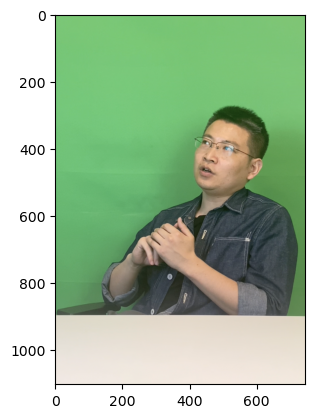

In [16]:
# load image

input_mean = 0.0
input_std = 1.0

img_path = "./align_img/fangzi.jpg"
image = cv2.imread(img_path, cv2.IMREAD_COLOR)  # origin image in BGR
# img = np.float32(image)

im_height, im_width, _ = image.shape
scale = torch.Tensor([image.shape[1], image.shape[0], image.shape[1], image.shape[0]])
scale = scale.to(device)


# img -= (104, 117, 123) # mean substruction to reduce illumination changes
# img = img.transpose(2, 0, 1)[None, :]

Batch_size = 1

# show the origin image
# plt.imshow(image[:,:,::-1]/255)
plt.imshow(image[:,:,::-1]/255)

print("image",image.shape)

In [17]:
#image2 = cv2.imread(img_path2, cv2.IMREAD_COLOR)  # origin image in BGR
torchlm.runtime.bind(faceboxesv2(device=device.__str__()))  # set device="cuda" if you want to run with CUDA
# set map_location="cuda" if you want to run with CUDA
torchlm.runtime.bind(
  pipnet(backbone="resnet101", weights =True,  
         num_nb=10, num_lms=68, net_stride=32, input_size=256,
         meanface_type="300w", map_location='cpu', checkpoint=None) 
) # will auto download pretrained weights from latest release if pretrained=True
landmarks, bboxes = torchlm.runtime.forward(image)

In [18]:
# input_shape2 = B*3*192*192

feed_img = torch.tensor(image,device=device).float()

### bbox
bbox = torch.from_numpy(bboxes[:,:4]).float().to(device)


bbox_size = bbox[:,2:4] - bbox[:,0:2]
w, h = bbox_size[:,0], bbox_size[:,1]

input_shape2 = ['None', 3, 192, 192]

input_size = tuple(input_shape2[2:4][::-1])
_scale =  1 / bbox_size.max(-1, keepdim=True)[0] * input_size[0]/1.2
center = (bbox[:,0:2] + bbox[:,2:4])/2
#torch.Tensor([(bbox[2] + bbox[0]) / 2, (bbox[3] + bbox[1]) / 2]).to(device)

# rotate = torch.zeros(Batch_size).to(device)
# #_scale = input_size[0]  / (max(w, h)*1.5)

# # transform from origin image to bbox image with input_size
# M_torch = transform_torch(center, bbox_size[0], _scale, rotate)
# IM = torch.linalg.inv(M_torch)[0:2,:]
# Jt = warp_img_torch(feed_img.permute(2,0,1).unsqueeze(0), M_torch, input_size)
# Jt = torch.clip(Jt, 0, 255)

# plt.imshow(Jt[0].permute(1,2,0).cpu().numpy()[:,:,::-1]/255)

In [19]:
landmarks_tensor = torch.from_numpy(landmarks).to(device)
list68to25 = list(range(17,37))+[39,42,45,48,54]
lmrks_25 = landmarks_tensor[:,list68to25,:].view(Batch_size,25,2)

uni_landmarks_25 = torch.from_numpy(uni_landmarks_25_np).to(device).unsqueeze(0)
# uni_landmarks_25 = torch.from_numpy(uni_landmarks_68).to(device).repeat(Batch_size,1,1)

Similarity_Matrix_3d_final = SimilarityTransform_torch_2D(lmrks_25, uni_landmarks_25)
Similarity_Matrix_3d_inversed = torch.inverse(Similarity_Matrix_3d_final)

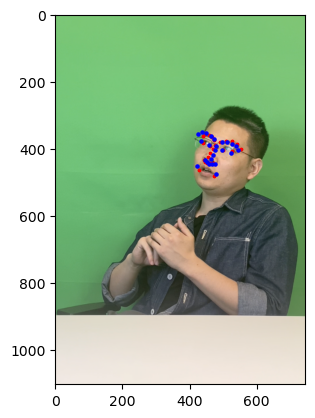

In [20]:
uni_landmarks_25_inversed = torch.matmul(uni_landmarks_25,Similarity_Matrix_3d_inversed[:,:2,:2].transpose(-1,-2)) + Similarity_Matrix_3d_inversed[:,:2,2].unsqueeze(-1).transpose(-1,-2)
uni_landmarks_25_inversed_np = uni_landmarks_25_inversed[0].cpu().numpy()
lmrks_25_np = lmrks_25[0].cpu().numpy()

plt.imshow(image[...,::-1])
plt.scatter(lmrks_25_np[:,0], lmrks_25_np[:,1], c='r', s=3)
plt.scatter(uni_landmarks_25_inversed_np[:,0], uni_landmarks_25_inversed_np[:,1], c='b', s=5)

face_align_img.shape: torch.Size([1, 3, 746, 746])
lmrks_align.shape: torch.Size([1, 68, 2])
center_align.shape: torch.Size([1, 1, 2])
torch.Size([1, 3, 746, 746])


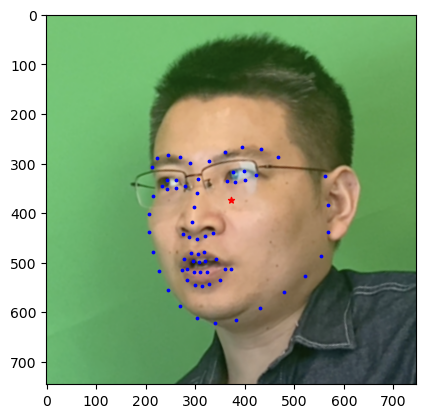

In [21]:
theta = torch.arctan(Similarity_Matrix_3d_final[:,1,0]/Similarity_Matrix_3d_final[:,0,0])*180/torch.pi
#theta = torch.ones_like(theta)*30
output_size = min(feed_img.shape[:2])
# output_size_w = 746
# output_size_h = 1102 

coverage = 0.6*min(feed_img.shape[:2])/bbox_size.max()


#center_0 = 0*torch.tensor(feed_img.shape[:2],device=device).unsqueeze(0)/2

face_align_matrix = transform_torch(center, (output_size, output_size), coverage, theta)

center_align = torch.matmul(center,face_align_matrix[:,:2,:2].transpose(-1,-2)) + face_align_matrix[:,:2,2]

face_align_matrix[:,:2,2:3] += - center_align.transpose(-1,-2) + output_size/2


face_align_img = warp_img_torch(feed_img.permute(2,0,1).unsqueeze(0), face_align_matrix[0], (output_size, output_size))

face_align_img = torch.clip(face_align_img, 0, 255)

###lmrks_align is used to following process in DINET
lmrks_align = torch.matmul(landmarks_tensor,face_align_matrix[:,:2,:2].transpose(-1,-2)) + face_align_matrix[:,:2,2]


lmrks_align_np = lmrks_align[0].cpu().numpy()
center_align = torch.matmul(center,face_align_matrix[:,:2,:2].transpose(-1,-2)) + face_align_matrix[:,:2,2]
center_align_np = center_align[0].cpu().numpy()

plt.imshow(face_align_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)[...,::-1])
plt.scatter(lmrks_align_np[:,0], lmrks_align_np[:,1], c='b', s=3)
plt.scatter(center_align_np[:,0], center_align_np[:,1], c='r', s=20, marker='*')


print("face_align_img.shape:",face_align_img.shape) # 1 3 500 500 # 用这个做为新image 输入
print("lmrks_align.shape:",lmrks_align.shape) # 1 68 2  # 用这个作为新landmark 输入
print("center_align.shape:",center_align.shape) # 1 1 2
print(face_align_img.shape) # 1102 746 3

以下是恢复

In [22]:
origin_img = feed_img.permute(2,0,1).unsqueeze(0)
origin_img.shape
B, C, H, W = origin_img.shape

In [23]:
origin_img = feed_img.permute(2,0,1).unsqueeze(0)

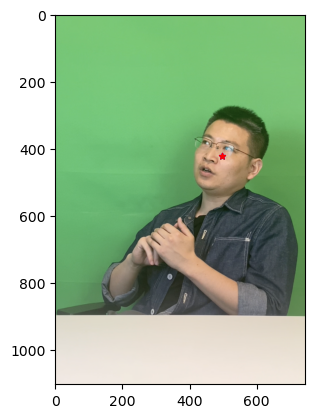

In [24]:
face_align_matrix_inversed = torch.inverse(face_align_matrix)

center_np = center.cpu().numpy()
#center_align_reversed = torch.matmul(center_align,face_align_matrix_inversed[:,:2,:2]) + face_align_matrix_inversed[:,:2,2].unsqueeze(-1).transpose(-1,-2)
center_align_reversed = torch.matmul(center_align,face_align_matrix_inversed[:,:2,:2].transpose(-1,-2)) + face_align_matrix_inversed[:,:2,2]

center_align_reversed_np = center_align_reversed[0].cpu().numpy()
plt.imshow(origin_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)[...,::-1])
plt.scatter(center_np[:,0], center_np[:,1], c='b',  s=20, marker='*')
plt.scatter(center_align_reversed_np[:,0], center_align_reversed_np[:,1], c='r',  s=20, marker='*')

In [26]:
grid_index_reversed[0,:,:,1].shape

torch.Size([746, 746])

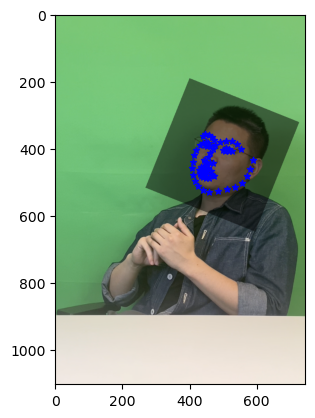

In [28]:
B, C, H, W = origin_img.shape
grid = F.affine_grid(torch.eye(3,device=device).unsqueeze(0)[:,0:2,:], torch.Size((B, C, output_size, output_size)))
grid_index =  (grid+1.0)*output_size/2.0
grid_index_reversed = torch.matmul(grid_index.view(B,-1,2),face_align_matrix_inversed[:,:2,:2].transpose(-1,-2)) + face_align_matrix_inversed[:,:2,2]
grid_index_reversed = grid_index_reversed.view(B,output_size,output_size,2).long()

lmrks_align_reversed = torch.matmul(lmrks_align,face_align_matrix_inversed[:,:2,:2].transpose(-1,-2)) + face_align_matrix_inversed[:,:2,2]
lmrks_align_reversed_np = lmrks_align_reversed[0].cpu().numpy()

reform_img = origin_img.clone()
fake_img = face_align_img/2
reform_img[:,:,grid_index_reversed[0,:,:,1], grid_index_reversed[0,:,:,0]] = fake_img
#torch.zeros_like(reform_img[0,:,grid_index_reversed[0,:,:,0], grid_index_reversed[0,:,:,1]])

plt.scatter(lmrks_align_reversed_np[:,0], lmrks_align_reversed_np[:,1], c='b',  s=20, marker='*')
plt.imshow(reform_img[0].permute(1,2,0).cpu().numpy().astype(np.uint8)[...,::-1])

请用 face_align_img 和 lmrks_align 继续做DINET后续处理
